In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from subprocess import call
from scipy.stats.distributions import gamma,lognorm
import json 
import wget
import os
import os.path

def n2z(x):
    x[np.logical_or(np.isnan(x),np.isinf(x))] = 0
    return x

if os.path.exists(os.getcwd()+"\\national.json"):
    os.remove(os.getcwd()+"\\national.json")
wget.download('https://api.covid19india.org/data.json', os.getcwd()+"\\national.json")

if os.path.exists(os.getcwd()+"\\states.json"):
    os.remove(os.getcwd()+"\\states.json")
wget.download('https://api.covid19india.org/states_daily.json', os.getcwd()+"\\states.json")


100% [........................................................] 203618 / 203618

'C:\\Users\\asus\\Documents\\GitHub\\CovidToday_Website\\reproduction-number-rt\\states.json'

In [3]:
def calc_doublingtimes(x):
    vals = []
    for i in range(x.shape[0]):
        for j in range(i+1,x.shape[0]):
            vals.append(np.log(2)*(j-i)/np.log(x[j]/x[i]))
    return np.mean(vals),np.mean(vals)-1.96*np.std(vals),np.mean(vals)+1.96*np.std(vals)

In [4]:
dates = np.array([pd.to_datetime(i['date']+"2020") for i in json.load(open('national.json',))['cases_time_series']])
confirmed = np.array([int(i['dailyconfirmed'])for i in json.load(open('national.json',))['cases_time_series']])
deceased = np.array([int(i['dailydeceased'])for i in json.load(open('national.json',))['cases_time_series']])
recovered = np.array([int(i['dailyrecovered'])for i in json.load(open('national.json',))['cases_time_series']])

confirmed = confirmed[dates>=pd.to_datetime("03/04/20")]
deceased = deceased[dates>=pd.to_datetime("03/04/20")]
recovered = recovered[dates>=pd.to_datetime("03/04/20")]
dates = dates[dates>=pd.to_datetime("03/04/20")]

In [5]:
cumul_cases = np.cumsum(confirmed)
dbt = np.zeros((3,cumul_cases.shape[0]))
for i in range(cumul_cases.shape[0]):
    dbt[:,i] = calc_doublingtimes(cumul_cases[i-7:i])

F:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


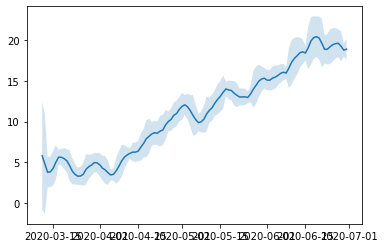

In [6]:
plt.plot(pd.to_datetime(dates),dbt[0,:])
plt.fill_between(pd.to_datetime(dates),dbt[1,:],dbt[2,:],alpha=0.2)

In [7]:
json_data = {}
india = {
        'dates':list(pd.Series(dates).dt.strftime('%m-%d-%Y')),
        'dbt_point':list(dbt[0,:]),
        'dbt_l95':list(dbt[1,:]),
        'dbt_u95':list(dbt[2,:])
        }
json_data['IN'] = india

### State Level Data

In [8]:
states = list(filter(lambda v:len(v)<3,list(json.load(open('states.json',))['states_daily'][0].keys())))

In [9]:
dates = np.array([pd.to_datetime(i['date']) for i in filter(lambda v: v['status'] == 'Confirmed',json.load(open('states.json',))['states_daily'])])
data_recovered = pd.DataFrame()
data_deceased = pd.DataFrame()
data_confirmed = pd.DataFrame()
for st in states:
    data_confirmed[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Confirmed',json.load(open('states.json',))['states_daily'])])
    data_deceased[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Deceased',json.load(open('states.json',))['states_daily'])])
    data_recovered[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Recovered',json.load(open('states.json',))['states_daily'])])

In [10]:
data_recovered = data_recovered.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_recovered = data_recovered.astype(np.int32)
data_confirmed = data_confirmed.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_confirmed = data_confirmed.astype(np.int32)
data_deceased = data_deceased.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_deceased = data_deceased.astype(np.int32)
data_deceased['date'] = dates
data_recovered['date'] = dates
data_confirmed['date'] = dates


In [11]:
state_id = { "mh":"Maharashtra",
  "tn":"Tamil Nadu",
  "dl":"Delhi",
  "gj":"Gujarat",
  "rj":"Rajasthan",
  "up":"Uttar Pradesh",
  "mp":"Madhya Pradesh",
  "wb":"West Bengal",
  "ka":"Karnataka",
  "br":"Bihar",
  "ap":"Andhra Pradesh",
  "hr":"Haryana",
  "tg":"Telangana",
  "jk":"Jammu and Kashmir",
  "or":"Odisha",
  "pb":"Punjab",
  "as":"Assam",
  "kl":"Kerala",
  "ut":"Uttarakhand",
  "jh":"Jharkand",
  "ct":"Chhattisgarh",
  "tr":"Tripura",
  "hp":"Himachal Pradesh",
  "ch":"Chandigarh",
  "ga":"Goa",
  "mn":"Manipur",
  "nl":"Nagaland",
  "py":"Puducherry",
  "la":"Ladakh",
  "ar":"Arunachal Pradesh",
  "an":"Andaman and Nicobar Islands",
  "ml":"Meghalaya",
  "mz":"Mizoram",
  "dn":"Dadra and Nagar Haveli and Daman and Diu",
  "sk":"Sikkim" }

for state in state_id.keys():
    cumul_cases = np.cumsum(data_confirmed[state].values)
    dbt = np.zeros((3,cumul_cases.shape[0]))
    for i in range(cumul_cases.shape[0]):
        dbt[:,i] = calc_doublingtimes(cumul_cases[i-7:i])
    temp = {
        'dates':list(pd.Series(dates).dt.strftime('%m-%d-%Y')),
        'dbt_point':list(dbt[0,:]),
        'dbt_l95':list(dbt[1,:]),
        'dbt_u95':list(dbt[2,:])
        }
    json_data[state] = temp

F:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
F:\Anaconda3\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr -

In [12]:
with open('dbt.json', 'w') as outfile:
    json.dump(json_data, outfile)